### Spectral matching with a simple FM chain — notebook guide

- **Goal**: Re-synthesize a target additive spectrum with a compact FM chain by optimizing oscillator parameters.
- **Workflow**:
  - Load target partials from `tsv/...`
  - Render the target (additive) signal for A/B comparison
  - Choose an objective (spectrum/MFCC) and an optimizer (DE/dual_annealing/CMA/Adam)
  - Optimize FM parameters → visualize spectra and error history
  - Save a preset → optional longer render or CLI render
- **Key modules**: `synthesis.py`, `synthesis_torch.py`, `objectives.py`, `objectives_torch.py`, `optimization.py`, `optimization_torch.py`, `plotting.py`, `generate_wave_file.py`, `utils.py`.
- **Quick start**: Adjust `OPTIMIZATION_CONFIG` (objective, method, oscillators, duration). Run the top cell, then use the follow-up cells for zoomed plots, longer render, and preset saving.



### Spectrum Target Settings (detailed)
- **Positive-frequency rFFT**: We compare spectra in the rFFT domain (non-negative frequencies only). This avoids duplicated energy from mirrored negative bins.
- **Windowing**: A Hann window is applied before FFT to reduce leakage and stabilize gradients around slightly detuned peaks. Optional zero-padding to the next power-of-two improves frequency resolution and smooths objectives.
- **Modes** (`OPTIMIZATION_CONFIG['target_spectrum_mode']`):
  - `sparse` (default): Places impulses at target partial bins with normalized amplitudes. Very focused; fast and robust, but sensitive to detuning.
  - `full`: Uses the full rFFT magnitude of the rendered additive target (normalized). Captures inharmonic content and off-bin energy; more tolerant to detuning.
  - `peaks_windowed`: Sums Gaussians centered at partial frequencies with widths controlled by `gaussian_sigma_hz`. More robust to small frequency shifts while keeping the objective focused on partial regions.
- **Key parameters**:
  - `gaussian_sigma_hz`: Gaussian width in Hz for `peaks_windowed` (e.g., 20–120 Hz). You can anneal this across runs (start wide, end narrow).
  - `fft_zero_pad`: If True, pad the time-domain signal to the next power-of-two before rFFT.
  - `fft_window`: `'hann'` by default. Keep consistent between target and generated spectra.
- **Recommendations**:
  - Start with `peaks_windowed` and a larger `gaussian_sigma_hz` (e.g., 120 Hz), then narrow to 30→10 Hz.
  - For final polish or delicate matches, use `full` with composite spectral loss (Adam) or keep `sparse` for fast global search (DE/CMA).



### FM chain parameter semantics
- Params are `[f1, a1, f2, a2, ...]` where Osc 1 is the carrier.
- Synthesis is `y(t) = a1·sin(2πf1 t + a2·sin(2πf2 t + a3·sin(...)))`.
- Thus, `a2..aN` act as modulation indices (phase depth), not output amplitudes.
- Consider tighter bounds for modulators (e.g., `a∈[0, 10]`) to avoid overly broad, noisy spectra.



### Objectives and optimizers overview
- **Objectives**:
  - **cosine_similarity**: scale-invariant angle between spectra; good general-purpose similarity.
  - **euclidean_distance**: L2 distance; sensitive to scale; useful with normalized spectra.
  - **pearson_correlation_coefficient**: 1 − corr; shape-focused, scale-invariant up to mean/variance.
  - **itakura_saito**: asymmetric divergence; emphasizes low-energy regions; typical for spectral envelopes.
  - **kl_divergence**: KL(P||Q) on normalized spectra (P=target); penalizes missing energy in the reconstruction.
  - **jensen_shannon**: symmetric, bounded KL; stable choice on normalized spectra.
  - **hellinger** / **bhattacharyya**: distances between spectral distributions; robust and simple.
  - **log_spectral_distance**: RMSE of log-magnitude; robust to gain; use with `peaks_windowed` targets.
  - **log_spectral_distance_weighted**: LSD with target-weighting and log1p compression; avoids DC collapse.
  - **erb_log_l1** / **erb_log_l2**: log-distance on ERB-band energies; perceptually motivated band match.
  - **beta_divergence:<β>**: unified family (β=2≈L2²/2, β→1 KL, β→0 IS); pass e.g. `beta_divergence:1.0`.
  - **mfcc_distance**: distance in cepstral space; perceptual envelope match; less sensitive to fine harmonics.
- **Optimizers**:
  - **differential_evolution**: strong global search; robust default; parallel-friendly.
  - **dual_annealing**: global search with stochastic visiting + optional local refinement.
  - **cma**: covariance-adapting local/global search; benefits from scaling and restarts.
  - **adam**: gradient-based refinement; best with smooth, scale-invariant spectral losses; fast on GPU.



### Optimization pipeline mode
- Define a sequence of optimizers to run one after another. The best params from each step seed the next.
- Recommended chains:
  - `DE → CMA → Adam`: strong global → covariance-shape refine → gradient polish
  - `DE → DA → CMA`: broader exploration → local refine
  - `CMA → Adam`: when you want a quicker local search then polish
- Per-step overrides:
  - Each step can override spectrum target mode or Gaussian width (curriculum), and its own optimizer params/budget.
- How to use:
  - Set `OPTIMIZATION_CONFIG['optimization_pipeline']` to a non-empty list of step dicts; pipeline takes precedence over single `method`.
  - Example:
  
```python
'optimization_pipeline': [
    {'method': 'differential_evolution', 'max_iterations': 300, 'optimizer_params': {'popsize': 15}},
    {'method': 'cma', 'max_iterations': 8000, 'optimizer_params': {'sigma0': 0.3, 'options': {'CMA_diagonal': True, 'CMA_active': True, 'popsize': 20}, 'num_restarts': 1}},
    {'method': 'adam', 'max_iterations': 5000, 'optimizer_params': {'learning_rate': 2e-3, 'adam_use_adamw': True, 'adam_loss_mode': 'composite'}}
]
```


In [29]:
# Reproducibility and defaults
import os, random
import numpy as np
import torch

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
if torch.cuda.is_available():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)



### Configuration reference (key options)
- General: `file_path`, `duration`, `sample_rate`, `n_oscillators`
- Objective: `objective_type` in {`cosine_similarity`, `euclidean_distance`, `pearson_correlation_coefficient`, `itakura_saito`, `kl_divergence`, `jensen_shannon`, `hellinger`, `bhattacharyya`, `log_spectral_distance`, `log_spectral_distance_weighted`, `erb_log_l1`, `erb_log_l2`, `mfcc_distance`, `beta_divergence:<beta>`}
- Spectrum:
  - `target_spectrum_mode`: `sparse` | `full` | `peaks_windowed`
  - `gaussian_sigma_hz`: Gaussian width for peak windows (Hz)
  - `fft_zero_pad`: zero-pad to next power-of-two (True/False)
  - `fft_window`: `'hann'`
- Optimizer:
  - `method`: `differential_evolution` | `dual_annealing` | `cma` | `adam`
  - `max_iterations`, `force_full_iters` (where applicable)
  - `optimizer_params`: per-optimizer settings (DE `popsize`; DA `maxfun`, `visit`, `initial_temp`; CMA `sigma0`, `options`, `num_restarts`; Adam `learning_rate`, etc.)



In [30]:
# Ensure latest local module edits are active in this session
import sys, importlib

# Make sure current directory is importable
if '' not in sys.path:
    sys.path.insert(0, '')

import objectives, optimization, optimization_torch, plotting
importlib.reload(objectives)
importlib.reload(optimization)
importlib.reload(optimization_torch)
importlib.reload(plotting)

# Optionally re-import selected functions after reload (main cell also imports explicitly)
from objectives import prepare_target, compute_fft
from optimization import define_objective_function, run_optimization


### 1. Original Target Sound (from TSV)

Generating audio from target partials for comparison...
[2025-08-19 20:05:39] File saved successfully to: rendered_audio\target_additive_cello.wav


Generating and analyzing target signal...


### 2. Running Optimization

Optimizing with cma:   0%|          | 0/50000 [00:00<?, ?eval/s]

Running cma.fmin2 with options: {'CMA_diagonal': True, 'CMA_active': True, 'popsize': 20} and sigma0=0.3
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 8 (seed=666352, Tue Aug 19 20:05:39 2025)
   Covariance matrix is diagonal
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 6.873271345692393e-01 1.1e+00 2.69e-01  3e-01  3e-01 0:00.1
    2     40 6.908786401061427e-01 1.0e+00 2.90e-01  3e-01  4e-01 0:00.1
    3     60 6.908766763523276e-01 1.0e+00 2.91e-01  3e-01  4e-01 0:00.2
   60   1200 5.670232933886239e-01 1.0e+00 1.51e-01  1e-03  2e-01 0:03.2
  100   2000 4.965905010087389e-01 1.0e+00 1.56e-02  7e-08  2e-02 0:05.3
  136   2720 4.965904955391167e-01 1.0e+00 7.15e-03  9e-11  3e-02 0:07.1
termination on tolfun=1e-11 (Tue Aug 19 20:05:46 2025)
final/bestever f-value = 4.965905e-01 4.965905e-01 after 2721/2676 evaluations
incumbent solution: [-0.58967978, 0.26264268, 0.02941673, 0.18382945, -0.17380033, -0.18028157, -0.10833151, 0.59750558]
std d

### 3. Optimization Results


Optimization Complete.
Final Objective Value: 0.49659049553911394
Generating final audio using the 'cma' synthesis engine...


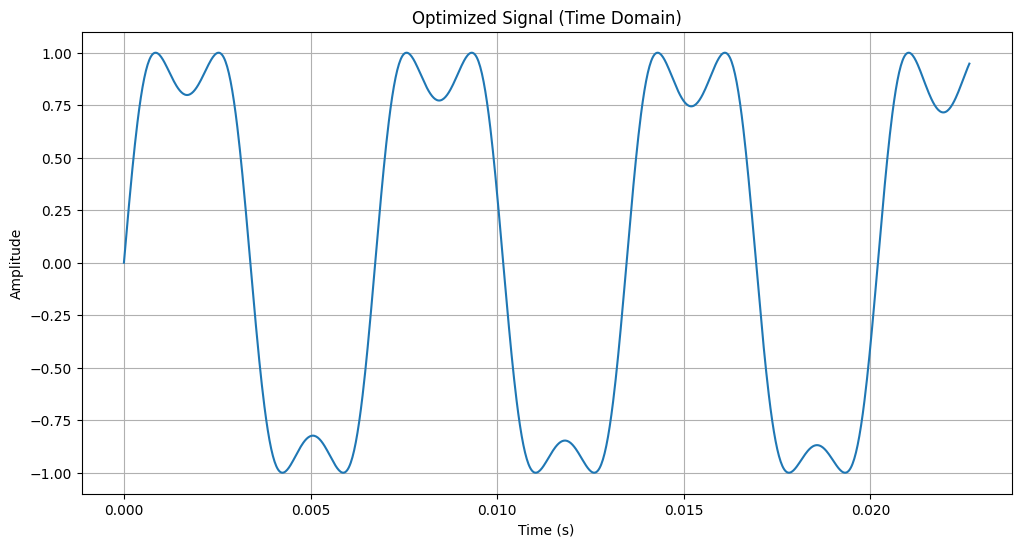

Using custom x-axis limit for plot: 15000 Hz


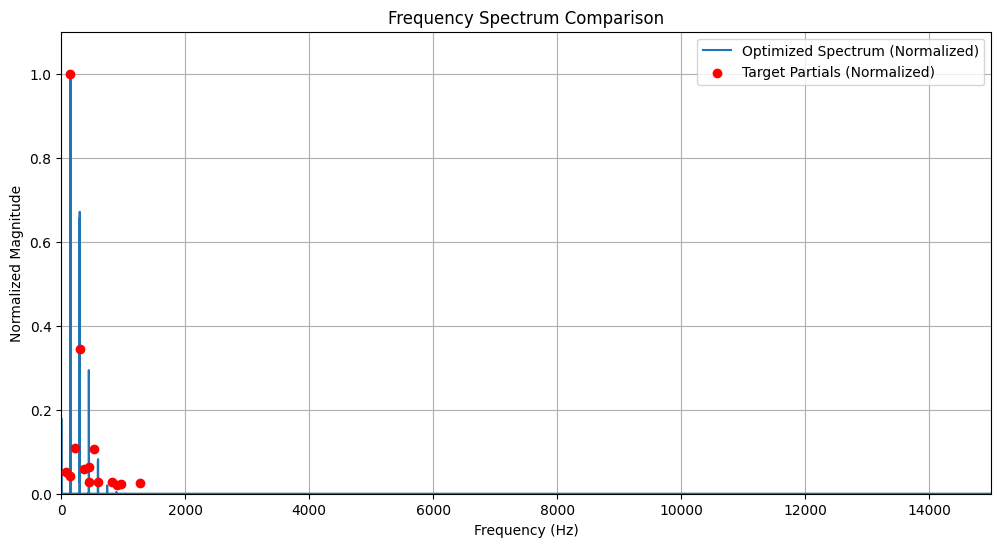

No error history to plot (possibly due to optimizer choice).

Optimal Parameters:
  Oscillator 1 (Carrier):
    Frequency: 1.00 Hz
    Amplitude: 3.12

  Oscillator 2 (Modulator for Osc 1):
    Frequency: 148.05 Hz
    Amplitude: 2.21

  Oscillator 3 (Modulator for Osc 2):
    Frequency: 1.00 Hz
    Amplitude: 0.00

  Oscillator 4 (Modulator for Osc 3):
    Frequency: 1.00 Hz
    Amplitude: 7.25



### 4. Optimized Sound (FM Synthesis)

[2025-08-19 20:05:59] File saved successfully to: rendered_audio\optimized_fm_cello_cma_jensen_shannon.wav


In [31]:
# main.py
import numpy as np
from IPython.display import Audio, display, Markdown
import os
import librosa
import cma

# --- PyTorch Imports ---
import torch
from optimization_torch import run_adam_optimization
from synthesis_torch import synthesize_fm_chain_torch

# --- NumPy/SciPy Imports ---
from utils import load_data
from synthesis import synthesize_fm_chain, sine_wave
from objectives import prepare_target, compute_fft
from optimization import define_objective_function, run_optimization
from plotting import plot_time_domain_signal, plot_frequency_domain_signal, plot_error_history
from generate_wave_file import save_wave_file

# --- 1. Configuration ---

OPTIMIZATION_CONFIG = {
    # --- General Settings ---
    'file_path': 'tsv/cello_single.tsv',
    'duration': 1,
    'sample_rate': 44100,
    
    # --- Synthesis & Objective Settings ---
    'n_oscillators': 4,
    'objective_type': 'jensen_shannon', # 'erb_log_l1', 'erb_log_l2', 'bhattacharyya', 'hellinger', 'jensen_shannon', 'log_spectral_distance_weighted', 'log_spectral_distance', 'kl_divergence', 'mfcc_distance', 'euclidean_distance', 'cosine_similarity', 'pearson_correlation_coefficient', 'itakura_saito' 
    
    # Set to a frequency in Hz (e.g., 15000) to see a wider spectrum.
    # Set to None to use the default automatic scaling.
    'plot_xlim_max': 15000,

    # --- Spectrum Target Settings ---
    'target_spectrum_mode': 'sparse', # 'sparse' | 'full' | 'peaks_windowed'
    'gaussian_sigma_hz': 30.0,
    'fft_zero_pad': True,
    'fft_window': 'hann',
    
    # --- Optimization Pipeline ---
    # When non-empty, this takes precedence over single-method settings below.
    # 'optimization_pipeline': [
    # {'method': 'differential_evolution', 'max_iterations': 300, 'force_full_iters': True, 'optimizer_params': {'popsize': 15}},
    # {'method': 'cma', 'max_iterations': 10000, 'optimizer_params': {'sigma0': 0.3, 'options': {'CMA_diagonal': True, 'CMA_active': True, 'popsize': 20}, 'num_restarts': 1}},
    # {'method': 'adam', 'max_iterations': 5000, 'optimizer_params': {'learning_rate': 2e-3, 'adam_use_adamw': True, 'adam_loss_mode': 'composite'}}
    # ]

    # --- Optimization Algorithm Settings ---

    # 'method': 'differential_evolution',
    # 'max_iterations': 500,
    # 'force_full_iters': True, # This is the key!
    # 'optimizer_params': {}
    

    # 'method': 'dual_annealing',
    # 'max_iterations': 1000,
    # 'force_full_iters': False, # Not needed if we set maxfun manually
    # 'optimizer_params': {'maxfun': 2e7, 'visit': 3.0, 'initial_temp': 8000} # Give it a budget of 100 million calls
    

    'method': 'cma',
    'max_iterations': 50000, 
    'force_full_iters': False, # This flag is ignored by the CMA-ES implementation
    'optimizer_params': {'sigma0': 0.3, 'options': {'CMA_diagonal': True, 'CMA_active': True, 'popsize': 20}, 'num_restarts': 2} 
    

    # 'method': 'adam', # <-- Set the method to 'adam'
    # 'max_iterations': 10000, # For Adam, this is the number of update steps
    
    # # Pass specific parameters to the Adam optimizer
    # 'optimizer_params': {
    #     'learning_rate': 2e-3,
    #     'adam_use_adamw': True,
    #     'adam_loss_mode': 'composite',
    #     'adam_w_sc': 1.0,
    #     'adam_w_logmag': 0.5,
    #     'adam_w_cosine': 0.2,
    #     'adam_log_mag_scale': 1.0,
    #     'adam_grad_clip_norm': 1.0
    # } 



}


# Unpack config into variables for cleaner code below
FILE_PATH = OPTIMIZATION_CONFIG['file_path']
DURATION = OPTIMIZATION_CONFIG['duration']
SAMPLE_RATE = OPTIMIZATION_CONFIG['sample_rate']
N_OSCILLATORS = OPTIMIZATION_CONFIG['n_oscillators']
OBJECTIVE_TYPE = OPTIMIZATION_CONFIG['objective_type']
PIPELINE = OPTIMIZATION_CONFIG.get('optimization_pipeline', [])
if PIPELINE:
    OPTIMIZATION_METHOD = PIPELINE[-1].get('method', OPTIMIZATION_CONFIG.get('method', 'unknown'))
    MAX_ITERATIONS = PIPELINE[-1].get('max_iterations', OPTIMIZATION_CONFIG.get('max_iterations', 0))
    METHOD_LABEL = "-".join([step.get('method', 'unknown') for step in PIPELINE])
    PIPELINE_METHODS = [step.get('method', 'unknown') for step in PIPELINE]
else:
    OPTIMIZATION_METHOD = OPTIMIZATION_CONFIG['method']
    MAX_ITERATIONS = OPTIMIZATION_CONFIG.get('max_iterations', 0)
    METHOD_LABEL = OPTIMIZATION_METHOD
    PIPELINE_METHODS = []
PLOT_XLIM_MAX = OPTIMIZATION_CONFIG.get('plot_xlim_max') # Use .get() for safety

# --- 2. Load Data ---
frequencies, amplitudes = load_data(FILE_PATH)

# --- 3. Generate and Render Original Target Sound (Additive Synthesis) ---
display(Markdown("### 1. Original Target Sound (from TSV)"))
print("Generating audio from target partials for comparison...")

# Create the signal by summing sine waves
target_signal = np.zeros(int(SAMPLE_RATE * DURATION))
for freq, amp in zip(frequencies, amplitudes):
    target_signal += sine_wave(freq, amp, DURATION, SAMPLE_RATE)

# Normalize the target signal before saving
max_val = np.max(np.abs(target_signal))
if max_val > 0:
    target_signal /= max_val

# Save and display the target audio
target_audio_path = save_wave_file(
    signal=target_signal,
    source_sr=SAMPLE_RATE,
    filename="target_additive_cello.wav"
)
display(Audio(filename=target_audio_path))

# --- 4. Prepare NumPy Target Data (for non-Adam and comparison) ---
# It's okay to prepare this here, as it's used by multiple parts.
target_data_np = prepare_target(
    frequencies,
    amplitudes,
    DURATION,
    SAMPLE_RATE,
    OBJECTIVE_TYPE,
    target_spectrum_mode=OPTIMIZATION_CONFIG.get('target_spectrum_mode', 'sparse'),
    gaussian_sigma_hz=OPTIMIZATION_CONFIG.get('gaussian_sigma_hz', 30.0),
    fft_zero_pad=OPTIMIZATION_CONFIG.get('fft_zero_pad', True),
    fft_window=OPTIMIZATION_CONFIG.get('fft_window', 'hann'),
)

# --- 5. Define Optimization Problem ---
bounds = []
for i in range(N_OSCILLATORS):
    bounds.append((1, 5000))
    bounds.append((0, 12))

# --- 6. Run Optimization ---
display(Markdown("### 2. Running Optimization"))
PIPELINE_DONE = False
if OPTIMIZATION_CONFIG.get('optimization_pipeline'):
    error_history = []
    current_params = None
    last_result = None
    last_method = None
    pipeline = OPTIMIZATION_CONFIG['optimization_pipeline']
    for step in pipeline:
        method = step.get('method')
        max_iters = int(step.get('max_iterations', MAX_ITERATIONS))
        force_full = bool(step.get('force_full_iters', OPTIMIZATION_CONFIG.get('force_full_iters', False)))
        step_fft_zero_pad = step.get('fft_zero_pad', OPTIMIZATION_CONFIG.get('fft_zero_pad', True))
        step_fft_window = step.get('fft_window', OPTIMIZATION_CONFIG.get('fft_window', 'hann'))
        step_target_mode = step.get('target_spectrum_mode', OPTIMIZATION_CONFIG.get('target_spectrum_mode', 'sparse'))
        step_gauss_sigma = step.get('gaussian_sigma_hz', OPTIMIZATION_CONFIG.get('gaussian_sigma_hz', 30.0))
        step_optimizer_params = dict(step.get('optimizer_params', {}))

        # Prepare target features for this step
        if OBJECTIVE_TYPE != 'mfcc_distance':
            target_data_for_step = prepare_target(
                frequencies, amplitudes, DURATION, SAMPLE_RATE, OBJECTIVE_TYPE,
                target_spectrum_mode=step_target_mode,
                gaussian_sigma_hz=step_gauss_sigma,
                fft_zero_pad=step_fft_zero_pad,
                fft_window=step_fft_window,
            )
        else:
            target_data_for_step = prepare_target(
                frequencies, amplitudes, DURATION, SAMPLE_RATE, OBJECTIVE_TYPE,
            )

        if method in ['differential_evolution', 'dual_annealing', 'cma']:
            objective_function = define_objective_function(
                OBJECTIVE_TYPE,
                target_data_for_step,
                DURATION,
                SAMPLE_RATE,
                fft_zero_pad=step_fft_zero_pad,
                fft_window=step_fft_window,
            )
            # Seeding for subsequent steps
            if current_params is not None:
                if method == 'cma':
                    step_optimizer_params.setdefault('x0', current_params)
                elif method == 'dual_annealing':
                    step_optimizer_params.setdefault('x0', current_params)
            result, step_history = run_optimization(
                method=method,
                bounds=bounds,
                objective_func=objective_function,
                max_iters=max_iters,
                force_full_iters=force_full,
                **step_optimizer_params
            )
            current_params = result.x
            last_result = result
            last_method = method
            error_history.extend(step_history or [])
        elif method == 'adam':
            # Build torch target
            if OBJECTIVE_TYPE != 'mfcc_distance':
                target_data_torch = torch.from_numpy(target_data_for_step).float()
            else:
                from objectives_torch import compute_mfcc_torch
                target_signal_torch = torch.from_numpy(target_signal).float()
                target_data_torch = compute_mfcc_torch(target_signal_torch, SAMPLE_RATE)
            if current_params is None:
                init_params = [np.random.uniform(low, high) for low, high in bounds]
            else:
                init_params = current_params.tolist()
            result, step_history = run_adam_optimization(
                objective_type=OBJECTIVE_TYPE,
                target_data=target_data_torch,
                initial_params=init_params,
                bounds=bounds,
                duration=DURATION,
                sample_rate=SAMPLE_RATE,
                max_iters=max_iters,
                fft_zero_pad=step_fft_zero_pad,
                fft_window=step_fft_window,
                loss_mode=step_optimizer_params.get('adam_loss_mode', OPTIMIZATION_CONFIG.get('optimizer_params', {}).get('adam_loss_mode', 'metric')),
                w_sc=step_optimizer_params.get('adam_w_sc', OPTIMIZATION_CONFIG.get('optimizer_params', {}).get('adam_w_sc', 1.0)),
                w_logmag=step_optimizer_params.get('adam_w_logmag', OPTIMIZATION_CONFIG.get('optimizer_params', {}).get('adam_w_logmag', 0.5)),
                w_cosine=step_optimizer_params.get('adam_w_cosine', OPTIMIZATION_CONFIG.get('optimizer_params', {}).get('adam_w_cosine', 0.2)),
                log_mag_scale=step_optimizer_params.get('adam_log_mag_scale', OPTIMIZATION_CONFIG.get('optimizer_params', {}).get('adam_log_mag_scale', 1.0)),
                grad_clip_norm=step_optimizer_params.get('adam_grad_clip_norm', OPTIMIZATION_CONFIG.get('optimizer_params', {}).get('adam_grad_clip_norm', 1.0)),
                use_adamw=step_optimizer_params.get('adam_use_adamw', OPTIMIZATION_CONFIG.get('optimizer_params', {}).get('adam_use_adamw', False)),
                learning_rate=step_optimizer_params.get('learning_rate', OPTIMIZATION_CONFIG.get('optimizer_params', {}).get('learning_rate', 1e-3)),
            )
            current_params = result.x
            last_result = result
            last_method = method
            error_history.extend(step_history or [])
        else:
            raise ValueError(f"Unsupported method in pipeline: {method}")
    optimal_params = current_params
    result = last_result
    OPTIMIZATION_METHOD = last_method
    PIPELINE_DONE = True

if PIPELINE_DONE:
    pass
elif OPTIMIZATION_METHOD in ['differential_evolution', 'dual_annealing', 'cma']:
    # --- FIX #2: Define the SciPy objective function only when needed ---
    objective_function = define_objective_function(
        OBJECTIVE_TYPE,
        target_data_np,
        DURATION,
        SAMPLE_RATE,
        fft_zero_pad=OPTIMIZATION_CONFIG.get('fft_zero_pad', True),
        fft_window=OPTIMIZATION_CONFIG.get('fft_window', 'hann'),
    )
    result, error_history = run_optimization(
        method=OPTIMIZATION_METHOD,
        bounds=bounds,
        objective_func=objective_function,
        max_iters=MAX_ITERATIONS,
        force_full_iters=OPTIMIZATION_CONFIG.get('force_full_iters', False),
        **OPTIMIZATION_CONFIG.get('optimizer_params', {})
    )
    optimal_params = result.x

elif OPTIMIZATION_METHOD == 'adam':
    # --- FIX #1: The COMPLETE Adam workflow block ---
    from objectives_torch import TORCH_METRIC_FEATURE_TYPE
    feature_type = TORCH_METRIC_FEATURE_TYPE.get(OBJECTIVE_TYPE)

    print(f"Preparing PyTorch target for objective: {OBJECTIVE_TYPE}")
    if feature_type == 'spectrum':
        target_data_torch = torch.from_numpy(target_data_np).float()
    elif feature_type == 'mfcc':
        from objectives_torch import compute_mfcc_torch
        target_signal_torch = torch.from_numpy(target_signal).float() # Use the target signal from Step 3
        target_data_torch = compute_mfcc_torch(target_signal_torch, SAMPLE_RATE)
    else:
        raise ValueError(f"Unsupported feature type for Adam: {feature_type}")
    
    initial_params = [np.random.uniform(low, high) for low, high in bounds]
    
    # The crucial missing call to run the optimization
    result, error_history = run_adam_optimization(
        objective_type=OBJECTIVE_TYPE,
        target_data=target_data_torch,
        initial_params=initial_params,
        bounds=bounds,
        duration=DURATION,
        sample_rate=SAMPLE_RATE,
        max_iters=MAX_ITERATIONS,
        fft_zero_pad=OPTIMIZATION_CONFIG.get('fft_zero_pad', True),
        fft_window=OPTIMIZATION_CONFIG.get('fft_window', 'hann'),
        loss_mode=OPTIMIZATION_CONFIG['optimizer_params'].get('adam_loss_mode', 'metric'),
        w_sc=OPTIMIZATION_CONFIG['optimizer_params'].get('adam_w_sc', 1.0),
        w_logmag=OPTIMIZATION_CONFIG['optimizer_params'].get('adam_w_logmag', 0.5),
        w_cosine=OPTIMIZATION_CONFIG['optimizer_params'].get('adam_w_cosine', 0.2),
        log_mag_scale=OPTIMIZATION_CONFIG['optimizer_params'].get('adam_log_mag_scale', 1.0),
        grad_clip_norm=OPTIMIZATION_CONFIG['optimizer_params'].get('adam_grad_clip_norm', 1.0),
        use_adamw=OPTIMIZATION_CONFIG['optimizer_params'].get('adam_use_adamw', False),
        learning_rate=OPTIMIZATION_CONFIG['optimizer_params'].get('learning_rate', 1e-3)
    )
    optimal_params = result.x
    # --- End of complete Adam block ---
else:
    pass

# --- 7. Process and Analyze Results ---
display(Markdown("### 3. Optimization Results"))
print("\nOptimization Complete.")
print(f"Final Objective Value: {result.fun}")

optimal_params = result.x
optimal_frequencies = optimal_params[0::2]
optimal_amplitudes = optimal_params[1::2]

# --- FIX #1: Use the correct synthesis function based on the method used ---
print(f"Generating final audio using the '{OPTIMIZATION_METHOD}' synthesis engine...")
if OPTIMIZATION_METHOD == 'adam':
    # Use the PyTorch synthesizer
    params_tensor = torch.from_numpy(optimal_params).float()
    optimized_signal_tensor = synthesize_fm_chain_torch(params_tensor, DURATION, SAMPLE_RATE)
    # Convert back to NumPy for plotting and saving
    optimized_signal = optimized_signal_tensor.detach().numpy()
else:
    # Use the NumPy synthesizer for all other methods
    optimized_signal = synthesize_fm_chain(optimal_params, DURATION, SAMPLE_RATE)
    
fft_magnitude, fft_freqs = compute_fft(
    optimized_signal,
    SAMPLE_RATE,
    zero_pad_to_next_pow2=OPTIMIZATION_CONFIG.get('fft_zero_pad', True),
    window=OPTIMIZATION_CONFIG.get('fft_window', 'hann'),
)

# Call the plotting functions with the new parameter
plot_time_domain_signal(optimized_signal, SAMPLE_RATE)
plot_frequency_domain_signal(
    fft_freqs,
    fft_magnitude,
    frequencies,
    amplitudes,
    xlim_max=PLOT_XLIM_MAX # Pass the new parameter here
)
plot_error_history(error_history)

# Print optimal parameters
print("\nOptimal Parameters:")
for i in range(N_OSCILLATORS):
    # --- THIS IS THE KEY CHANGE ---
    # The Carrier is now the FIRST oscillator in the list (index 0)
    # The last modulator in the chain is Oscillator N (index N-1)
    if i == 0:
        role = "Carrier"
    else:
        # Osc 2 modulates Osc 1, Osc 3 modulates Osc 2, etc.
        role = f"Modulator for Osc {i}"

    print(f"  Oscillator {i+1} ({role}):")
    print(f"    Frequency: {optimal_frequencies[i]:.2f} Hz")
    print(f"    Amplitude: {optimal_amplitudes[i]:.2f}\n")


# --- 8. Synthesize and Display Optimized Sound ---
display(Markdown("### 4. Optimized Sound (FM Synthesis)"))

# Save and display the optimized audio ONCE
# Use METHOD_LABEL (pipeline-aware) in filenames
output_filename = f'optimized_fm_cello_{METHOD_LABEL}_{OBJECTIVE_TYPE}.wav'
optimized_audio_path = save_wave_file(
    signal=optimized_signal,
    source_sr=SAMPLE_RATE,
    target_sr=44100,
    bit_depth=16,
    filename=output_filename
)
display(Audio(filename=optimized_audio_path))

### FM chain parameter semantics
- Params are `[f1, a1, f2, a2, ...]` where Osc 1 is the carrier.
- Synthesis is `y(t) = a1·sin(2πf1 t + a2·sin(2πf2 t + a3·sin(...)))`.
- Thus, `a2..aN` act as modulation indices (phase depth), not output amplitudes.
- Consider tighter bounds for modulators (e.g., `a∈[0, 10]`) to avoid overly broad, noisy spectra.



Using custom x-axis limit for plot: 4000 Hz


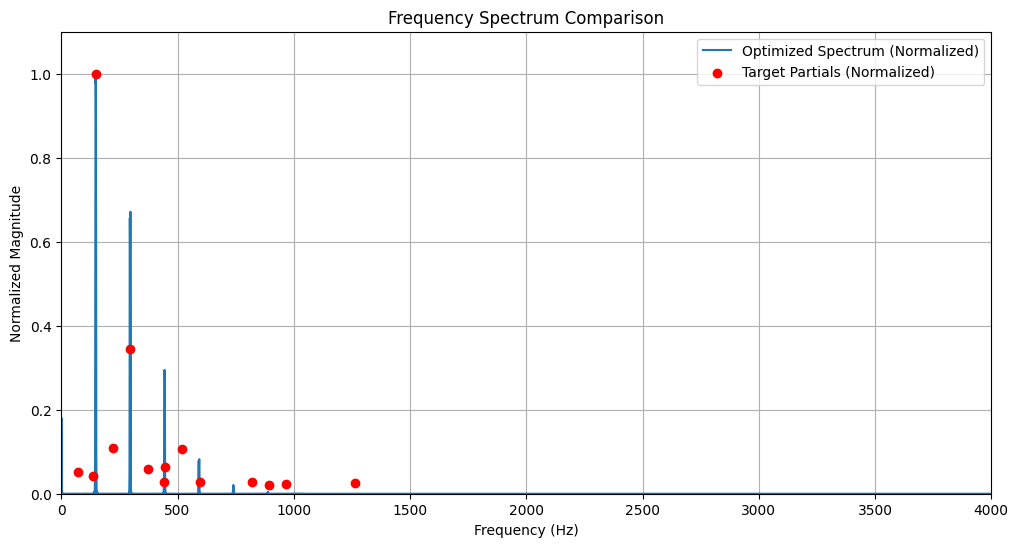

In [32]:
plot_frequency_domain_signal(
    fft_freqs,
    fft_magnitude,
    frequencies,
    amplitudes,
    xlim_max=4000 # Pass the new parameter here
)

In [33]:
# --- Follow-up Cell: Synthesize and Save a Longer Version ---

# You can change this to any desired duration in seconds
LONGER_DURATION = 10 

# You can also change the filename for the longer version
LONGER_FILENAME = f'optimized_fm_cello_{METHOD_LABEL}_{OBJECTIVE_TYPE}_{LONGER_DURATION}s.wav'

print(f"Synthesizing a longer {LONGER_DURATION}-second version of the optimized sound...")

# --- Synthesis Logic ---
# We use the same logic as in the main cell to decide which synthesis engine to use.
# The ONLY difference is that we pass LONGER_DURATION instead of DURATION.

if OPTIMIZATION_METHOD == 'adam':
    # Use the PyTorch synthesizer
    # Convert optimal_params (which is a NumPy array) back to a PyTorch tensor
    params_tensor = torch.from_numpy(optimal_params).float()
    
    # Synthesize with the longer duration
    longer_signal_tensor = synthesize_fm_chain_torch(params_tensor, LONGER_DURATION, SAMPLE_RATE)
    
    # Convert the final signal back to a NumPy array for saving
    longer_optimized_signal = longer_signal_tensor.detach().numpy()
else:
    # Use the NumPy synthesizer for all other methods
    longer_optimized_signal = synthesize_fm_chain(optimal_params, LONGER_DURATION, SAMPLE_RATE)

# --- Save and Display the Longer Audio ---

# Call the save_wave_file utility with the new signal and filename
longer_audio_path = save_wave_file(
    signal=longer_optimized_signal,
    source_sr=SAMPLE_RATE,
    target_sr=44100, # Or any other target sample rate
    bit_depth=16,
    filename=LONGER_FILENAME
)

# Display the audio player for the longer version
display(Markdown(f"### Optimized Sound ({LONGER_DURATION} seconds)"))
display(Audio(filename=longer_audio_path))

Synthesizing a longer 10-second version of the optimized sound...
[2025-08-19 20:06:00] File saved successfully to: rendered_audio\optimized_fm_cello_cma_jensen_shannon_10s.wav


### Optimized Sound (10 seconds)

In [34]:
# --- Follow-up Cell: Automatically Save Preset with a Descriptive Name ---
import os
from datetime import datetime
from utils import save_preset

# This cell assumes 'optimal_params' and 'OPTIMIZATION_CONFIG' 
# exist in memory from the previous cell run.

print("Automatically generating preset name and saving...")

# --- 1. Auto-generate a descriptive name ---
# Get the base name of the source file (e.g., 'cello_single')
source_name = os.path.basename(OPTIMIZATION_CONFIG['file_path']).split('.')[0]
method = OPTIMIZATION_METHOD  # final method used for synthesis engine selection
pipeline_label = METHOD_LABEL  # pipeline-aware label for filenames
pipeline_steps = PIPELINE_METHODS  # list of methods if pipeline used
objective = OPTIMIZATION_CONFIG['objective_type']
# Add a timestamp to ensure the filename is always unique
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Combine them into a single, descriptive filename (pipeline-aware)
auto_preset_name = f"{source_name}_{pipeline_label}_{objective}_{timestamp}"

# --- 2. Save the preset ---
preset_filepath = f'presets/{auto_preset_name}.json'

preset_metadata = {
    'optimization_method': method,            # final method
    'optimization_pipeline': pipeline_steps,  # full pipeline (if any)
    'pipeline_label': pipeline_label,         # cached label for convenience
    'objective_type': objective,
    'n_oscillators': OPTIMIZATION_CONFIG['n_oscillators'],
    'source_file': OPTIMIZATION_CONFIG['file_path'],
    'final_loss': result.fun 
}

save_preset(preset_filepath, optimal_params, preset_metadata)

Automatically generating preset name and saving...
Preset saved successfully to: presets/cello_single_cma_jensen_shannon_20250819_200600.json


In [35]:
# # --- Cell to Render Audio using the subprocess Module (with Debugging) ---
# import subprocess
# import shlex

# # Define the preset and duration
# preset_to_render = 'presets/testtt.json' # <-- DOUBLE-CHECK THAT THIS FILE EXISTS!
# render_duration = 15
# output_filename = "my_rendered_masterpiece.wav"

# # Build the command as a list of arguments
# command = [
#     "python",
#     "synthesizer_cli.py",
#     "render",
#     preset_to_render,
#     "--duration",
#     str(render_duration),
#     "--output",
#     output_filename
# ]

# # --- Run the command inside a try...except block to see the error ---
# print(f"Running command: {' '.join(command)}")
# try:
#     result = subprocess.run(command, capture_output=True, text=True, check=True)
    
#     # This part will only run if the command succeeds
#     print("\n--- Script Output (Success) ---")
#     print(result.stdout)
#     if result.stderr:
#         print("\n--- Script Warnings (Success) ---")
#         print(result.stderr)
    
#     print("\n--- Rendering Complete ---")
    
#     # Display the audio player on success
#     from IPython.display import Audio, display
#     display(Audio(filename=f'rendered_audio/{output_filename}'))

# except subprocess.CalledProcessError as e:
#     # This block will run if the command fails (returns a non-zero exit code)
#     print("\n--- SCRIPT FAILED ---")
#     print(f"Exit Code: {e.returncode}")
    
#     print("\n--- Script Output (stdout) ---")
#     # stdout might contain useful prints or partial output before the crash
#     print(e.stdout)
    
#     print("\n--- Script Error (stderr) ---")
#     # stderr will almost always contain the Python traceback from the failed script
#     print(e.stderr)